In [314]:
#각각의 요소별 생존 확률을 구한다.
#각 성별에 대한 생존 확률
#각 클래스에 대한 생존 확률

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 10
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier



#plt.rcParams['font.family'] = 'AppleGothic'  # 맥용 폰트
#plt.rcParams['font.size'] = 10


In [315]:
#데이터 읽기
df = pd.read_csv('train.csv')
#데이터 프레임의 요약 정보 결측치 확인 #나이 177개 결측치, Cabin 687개 결측치, Embarked 2개 결측치
print(df.isnull().sum())
df.info() #dtypes: float64(2), int64(5), object(5)
print(df.head())




train_df = pd.read_csv('train.csv') #학습 파일
test_df = pd.read_csv('test.csv') #평가 파일



PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
   

In [316]:
#데이터 프레임 출력
print(df)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ... 

In [317]:
# 전체 승객 수
PassengerId = df['PassengerId'].count()
print(f'전체 승객 수 : {PassengerId}')
# 전체 승객 중 생존자 수
print(f'전체 승객 중 생존자 수 : {df["Survived"].sum()}')


전체 승객 수 : 891
전체 승객 중 생존자 수 : 342


전체 생존자 비율 : 0.3838383838383838
생존자 중 여자 생존자 비율: 0.6812865497076024
생존자 중 남자 생존자 비율: 0.31871345029239767


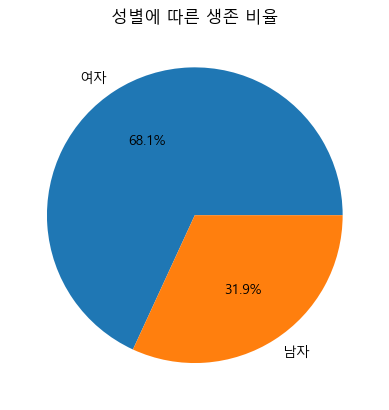

In [318]:
#전체 생존자 비율 생존자 = 1, 사망자 = 0
print(f"전체 생존자 비율 : {df['Survived'].mean()}")

# 생존자만 선택
survived = df[df['Survived'] == 1]
# 사망자만 선택
dead = df[df['Survived'] == 0]

# 생존자 중 남자 여자 비율
female_survived = survived[survived['Sex'] == 'female']
male_survived = survived[survived['Sex'] == 'male']

female_survived_ratio = len(female_survived)/len(survived)
male_survived_ratio = len(male_survived)/len(survived)

print('생존자 중 여자 생존자 비율:', female_survived_ratio)
print('생존자 중 남자 생존자 비율:', male_survived_ratio)

# 성별에 따른 생존 비율 그래프
plt.pie([female_survived_ratio, male_survived_ratio], labels=['여자', '남자'], autopct='%1.1f%%')
plt.title('성별에 따른 생존 비율')
plt.show()

전체 사망자 비율 : 0.6161616161616161
전체 사망자 중 여자 사망자  : 0.14754098360655737
전체 사망자 중 남자 사망자  : 0.8524590163934426


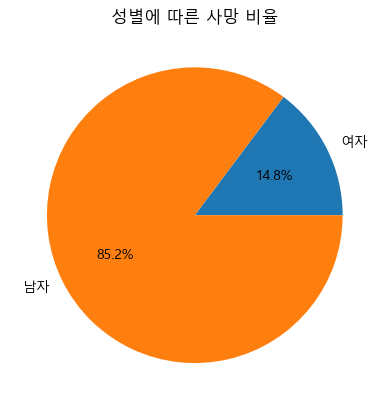

In [319]:
#전체 사망지 비율
print(f"전체 사망자 비율 : {1 - df['Survived'].mean()}")
#

female_dead = dead[dead['Sex'] == 'female']
male_dead = dead[dead['Sex'] == 'male']

female_dead_ratio = len(female_dead)/len(dead)
male_dead_ratio = len(male_dead)/len(dead)

print('전체 사망자 중 여자 사망자  :', len(female_dead)/len(dead))
print('전체 사망자 중 남자 사망자  :', len(male_dead)/len(dead))
#성별에 따른 사망 비율
plt.pie([female_dead_ratio,male_dead_ratio], labels=['여자', '남자'], autopct='%1.1f%%')
plt.title('성별에 따른 사망 비율')
plt.show()


등급별 생존 확률 
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


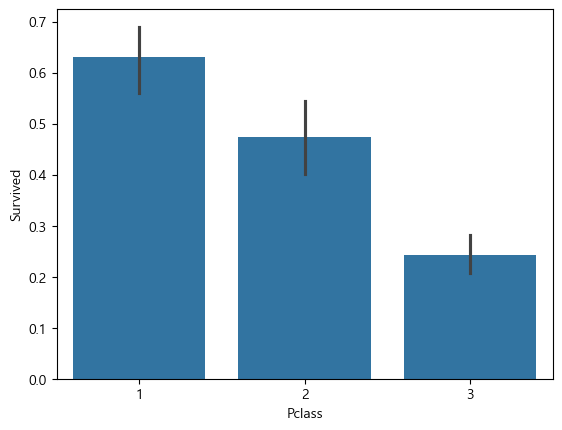

In [320]:
#좌석 등급별 생존자 비율
#좌석 등급에 따라 생존자 비율이 달라지는지 확인 등급은 총 3가지가 있음

print(f"등급별 생존 확률 \n{df.groupby('Pclass')['Survived'].mean()}")
#좌석 등급별 생존자 비율 시각화
sns.barplot(data=df, x='Pclass', y='Survived')
plt.show()
#그래프로 알 수 있는 것은 1등급이 생존률이 높고 3등급이 낮다
#3등급의 경우 생존률이 25%도 되지 않는다.
#1등급의 경우 생존률이 63%에 달한다.
#좌석 등급에 따라 생존률이 달라지는 것을 알 수 있다.




In [321]:
#등급별 티켓 가격 

Fare_class = df.groupby('Pclass')['Fare'].mean()
print(Fare_class)


Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64


Age_group
10대       0.401961
10대 미만    0.612903
20대       0.350000
30대       0.437126
40대       0.382022
50대       0.416667
60대       0.315789
70대 이상    0.288043
Name: Survived, dtype: float64


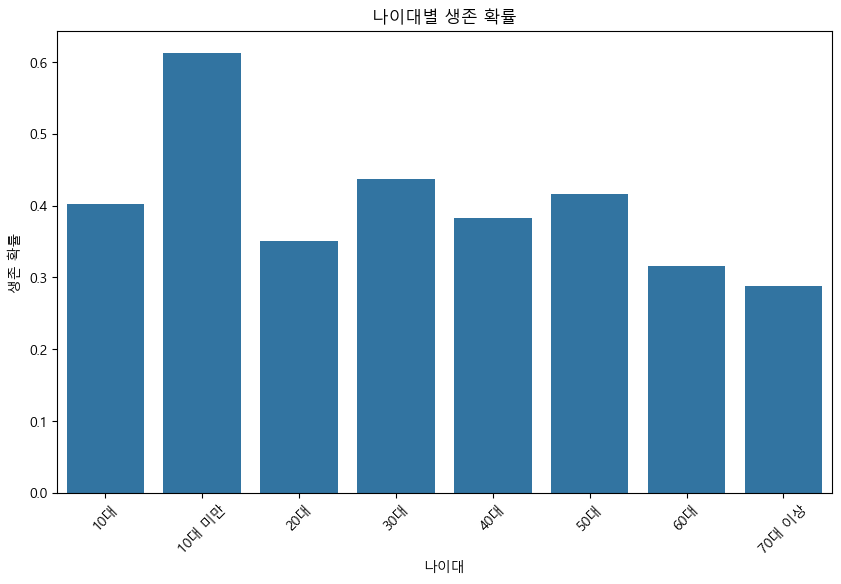

In [322]:
# 나이대를 구분하는 함수
def age_group(age):
    if age < 10:
        return '10대 미만'
    elif age < 20:
        return '10대'
    elif age < 30:
        return '20대'
    elif age < 40:
        return '30대'
    elif age < 50:
        return '40대'
    elif age < 60:
        return '50대'
    elif age < 70:
        return '60대'
    else:
        return '70대 이상'

# 승객 나이에 따라 그룹화
df['Age_group'] = df['Age'].apply(age_group)

# 나이대별 생존 확률 계산
age_survival = df.groupby('Age_group')['Survived'].mean()
print(age_survival)

# 나이대별 생존 확률 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=age_survival.index, y=age_survival.values)
plt.title('나이대별 생존 확률')
plt.xlabel('나이대')
plt.ylabel('생존 확률')
plt.xticks(rotation=45)
plt.show()

# 이후 분석이나 모델링에서 Age_group을 제외하고 진행
df = df.drop('Age_group', axis=1)

C:\Users\302\AppData\Local\Temp\ipykernel_14596\2678877980.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_null_delete['Age_group'] = age_null_delete['Age'].apply(age_group)


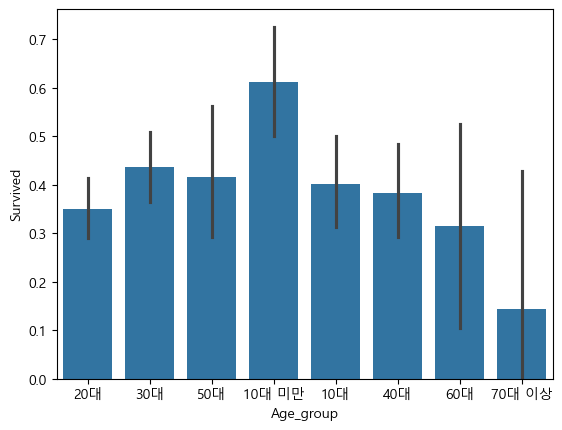

In [323]:
#나이 데이터 결측치 처리

age_null_delete = df.dropna(subset=['Age'])

#승객 나이 통계 확인하기
age_null_delete['Age'].describe()
#승객 나이에 따라 분류하기
age_null_delete['Age_group'] = age_null_delete['Age'].apply(age_group)
#승객 나이에 따른 생존 확률
age_null_delete.groupby('Age_group')['Survived'].mean()
#승객 나이에 따른 생존 확률 시각화
sns.barplot(x='Age_group', y='Survived', data=age_null_delete)
plt.show()

In [324]:
#운임비용에 따른 생존율
#운임비용이 높으면 생존율이 높을지에 대해서 Fare를 기준으로 분석
#

df['Fare'].describe()
#5
df['FareBand'] = pd.qcut(df['Fare'], 5)
df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)
#200불 이상은 생존율이 높다.

'''print(df['Fare'].min()) #요금에 이상치 있는지 확인 시 0원이 있음

print(df['Fare'].max())'''

df_sorted = df.sort_values(by='Fare', ascending=False)
high_10 = df_sorted.head(10)
low_10 = df_sorted.tail(10)

print(high_10)
print(low_10)



     PassengerId  Survived  Pclass                                   Name  \
258          259         1       1                       Ward, Miss. Anna   
737          738         1       1                 Lesurer, Mr. Gustave J   
679          680         1       1     Cardeza, Mr. Thomas Drake Martinez   
88            89         1       1             Fortune, Miss. Mabel Helen   
27            28         0       1         Fortune, Mr. Charles Alexander   
341          342         1       1         Fortune, Miss. Alice Elizabeth   
438          439         0       1                      Fortune, Mr. Mark   
311          312         1       1             Ryerson, Miss. Emily Borie   
742          743         1       1  Ryerson, Miss. Susan Parker "Suzette"   
118          119         0       1               Baxter, Mr. Quigg Edmond   

        Sex   Age  SibSp  Parch    Ticket      Fare            Cabin Embarked  \
258  female  35.0      0      0  PC 17755  512.3292              NaN   

C:\Users\302\AppData\Local\Temp\ipykernel_14596\1390922172.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)


탑승 항구 별 생존 확률 
Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64


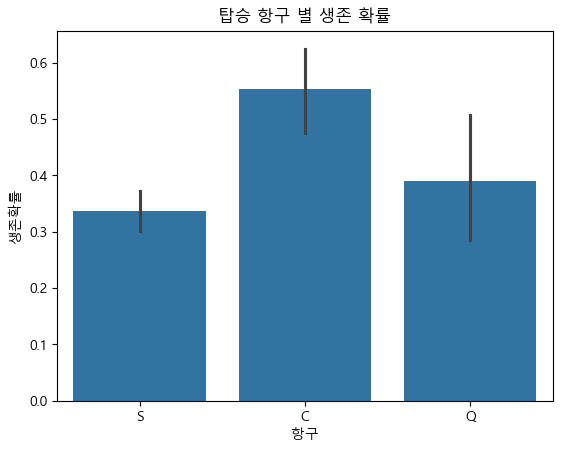

항구 별 가격 평균
Embarked
C    59.954144
Q    13.276030
S    27.079812
Name: Fare, dtype: float64
항구 별 티켓 등급
Embarked
C    1.886905
Q    2.909091
S    2.350932
Name: Pclass, dtype: float64


In [325]:
#탑승 항구에 따라 생존률이 달라지는지 확인


print(f"탑승 항구 별 생존 확률 \n{df.groupby('Embarked')['Survived'].mean()}")
#좌석 등급별 생존자 비율 시각화
sns.barplot(data=df, x='Embarked', y='Survived')
plt.title('탑승 항구 별 생존 확률')
plt.xlabel('항구')
plt.ylabel('생존확률')
plt.show()

print(f"항구 별 가격 평균\n{df.groupby('Embarked')['Fare'].mean()}" )
print(f"항구 별 티켓 등급\n{df.groupby('Embarked')['Pclass'].mean()}")

In [326]:
# Sibsp 과 Parch 0인 경우 혼자 탑승
# 1이상인 경우 동승자 있음

alone = df[df['SibSp'] == 0]
alone = alone[alone['Parch'] == 0]
print(alone['Survived'].value_counts())


#동승자가 있는 경우 생존률이 더 높은지 확인
#동승자가 있는 사람
Sibsp_Parch = df[df['SibSp'] > 0]
Sibsp_parch = Sibsp_Parch[Sibsp_Parch['Parch'] > 0]
print(Sibsp_Parch['Survived'].value_counts())

#동승자가 있는 경우 생존률이 더 높음

Survived
0    374
1    163
Name: count, dtype: int64
Survived
0    151
1    132
Name: count, dtype: int64


In [327]:
#모델 학습 시키기
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import seaborn as sns
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
X = df[['Pclass', 'Age', 'Sex', 'Fare']]
y = df['Survived']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('RandomForest 정확도 :', accuracy_score(y_test, y_pred))
print('혼동 행렬 :', confusion_matrix(y_test, y_pred))


RandomForest 정확도 : 0.7932960893854749
혼동 행렬 : [[89 16]
 [21 53]]


In [328]:
X = np.nan_to_num(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("LogisticRegression Accuracy:", accuracy_score(y_test, y_pred))



LogisticRegression Accuracy: 0.776536312849162


In [329]:
model = SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("SVC Accuracy:", accuracy_score(y_test, y_pred))

SVC Accuracy: 0.6536312849162011


In [330]:
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print('혼동 행렬 :', confusion_matrix(y_test, y_pred))

XGBoost Accuracy: 0.8044692737430168
혼동 행렬 : [[93 12]
 [23 51]]


In [331]:
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# XGBoost 모델 생성
xgb_model = xgb.XGBClassifier(random_state=42)

# GridSearchCV 설정
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 파라미터 출력
print("최적의 파라미터:", grid_search.best_params_)
print("최고의 정확도:", grid_search.best_score_)

# 최적의 파라미터로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("최적의 XGBoost 정확도:", accuracy_score(y_test, y_pred))
print('혼동 행렬 :', confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
최적의 파라미터: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
최고의 정확도: 0.8258518597312343
최적의 XGBoost 정확도: 0.8324022346368715
혼동 행렬 : [[93 12]
 [18 56]]


In [332]:
#결정 트리 모델 
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("DecisionTree Accuracy:", accuracy_score(y_test, y_pred))
print('혼동 행렬 :', confusion_matrix(y_test, y_pred))



DecisionTree Accuracy: 0.776536312849162
혼동 행렬 : [[89 16]
 [24 50]]


In [333]:
#데이터 전처리
fare_zero_less = df[df['Fare'] < 1]
print(f'요금 0이하의 데이터 개수 : {len(fare_zero_less)}')

# 요금 0 이하의 데이터 삭제
df = df[df['Fare'] > 0]

요금 0이하의 데이터 개수 : 15


In [334]:
# 이름에 성별 잘못 입력된 데이터 확인
# 이름에 Mr, Mrs, Miss, Master가 없는 데이터 확인
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=False)

# Title이 Mr, Mrs, Miss, Master에 포함되지 않은 데이터 필터링
invalid_titles = df[~df['Title'].isin(['Mr', 'Mrs', 'Miss', 'Master'])]

# 결과 출력
print(f"성별을 나타내는 문자가 없는 데이터 개수: {len(invalid_titles)}")
print(invalid_titles[['Name', 'Title']])


print(df.head())




성별을 나타내는 문자가 없는 데이터 개수: 26
                                                  Name     Title
30                            Uruchurtu, Don. Manuel E       Don
149                  Byles, Rev. Thomas Roussel Davids       Rev
150                         Bateman, Rev. Robert James       Rev
245                        Minahan, Dr. William Edward        Dr
249                      Carter, Rev. Ernest Courtenay       Rev
317                               Moraweck, Dr. Ernest        Dr
369                      Aubart, Mme. Leontine Pauline       Mme
398                                   Pain, Dr. Alfred        Dr
443                          Reynaldo, Ms. Encarnacion        Ms
449                     Peuchen, Major. Arthur Godfrey     Major
536                  Butt, Major. Archibald Willingham     Major
556  Duff Gordon, Lady. (Lucille Christiana Sutherl...      Lady
599       Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")       Sir
626                     Kirkland, Rev. Charles Leonard       Re

<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
C:\Users\302\AppData\Local\Temp\ipykernel_14596\1705049127.py:3: SyntaxWarning: invalid escape sequence '\.'
  df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=False)


동승자가 없는 경우 생존율: 0.3103448275862069
동승자가 있는 경우 생존률: 0.5056497175141242


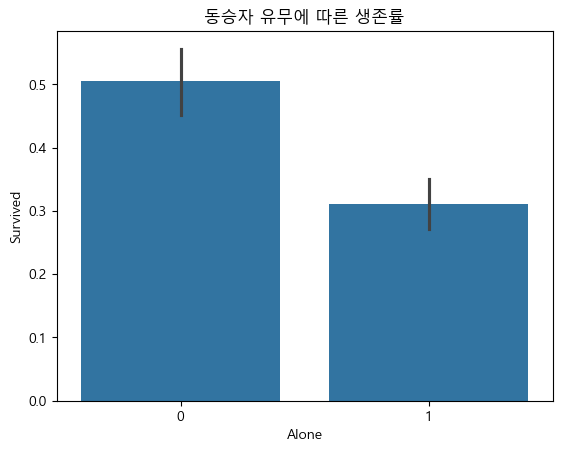

In [335]:
# 동승자 유무에 따른 생존률 확인
# 동승자가 없는 경우
alone = df[(df['SibSp'] == 0) & (df['Parch'] == 0)]
print(f'동승자가 없는 경우 생존율: {alone["Survived"].mean()}')

# 동승자가 있는 경우
not_alone = df[(df['SibSp'] > 0) | (df['Parch'] > 0)]
print(f'동승자가 있는 경우 생존률: {not_alone["Survived"].mean()}')

#df 에 Alone 컬럼 추가
df['Alone'] = 0
df.loc[(df['SibSp'] == 0) & (df['Parch'] == 0), 'Alone'] = 1


# 그래프로 확인
sns.barplot(data=df, x='Alone', y='Survived')
plt.title('동승자 유무에 따른 생존률')
plt.show()

In [336]:
# 필요없어 보이는 열 삭제
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Title','FareBand','Embarked','SibSp','Parch'], axis=1)


In [337]:
#삭제 후 데이터 확인
print(df.head(1))

#Age 평균 
age_mean = df['Age'].mean()
print(age_mean)

   Survived  Pclass  Sex   Age  Fare  Alone
0         0       3    0  22.0  7.25      0
29.645219236209332


In [338]:
# 나이 결측치를 삭제한 데이터 모델링 후 확인
# 모델링 학습시키기
X = df.drop('Survived', axis=1)
X = np.nan_to_num(X)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
#랜던 포레스트 모델 사용
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('RandomForest 정확도 :', accuracy_score(y_test, y_pred))

# 로지스틱 회귀 모델 사용
model = LogisticRegression(n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("LogisticRegression Accuracy:", accuracy_score(y_test, y_pred))

# XGBoost 모델 사용
model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))

#결정 트리 모델
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("DecisionTree Accuracy:", accuracy_score(y_test, y_pred))



RandomForest 정확도 : 0.8181818181818182
LogisticRegression Accuracy: 0.7954545454545454
XGBoost Accuracy: 0.8333333333333334
DecisionTree Accuracy: 0.7727272727272727


In [339]:
test_df = pd.read_csv('test.csv')
print(test_df.head(1))

#필요 없는 열 삭제
test_df = test_df.drop(['Name', 'Ticket', 'Cabin', 'Embarked','SibSp','Parch'], axis=1)
print(test_df.head(1))

#결측치 확인
print(test_df.isnull().sum())

#결측치 처리 평균값으로
test_df['Age'] = test_df['Age'].fillna(age_mean)
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].mean())
# 문자열 데이터를 숫자형으로 변환 (예: 'Sex' 열)
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})


#모델링하여 생존률 예측하기
model = xgb.XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)  # X_train, y_train은 학습 데이터

y_pred = model.predict(test_df)

# 예측 결과를 테스트 데이터에 추가
test_df['Survived'] = y_pred

# 결과 확인
print(test_df[['PassengerId', 'Survived']].head())

# 결과를 CSV 파일로 저장
test_df[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)
print("예측 결과가 'submission.csv' 파일로 저장되었습니다.")



   PassengerId  Pclass              Name   Sex   Age  SibSp  Parch  Ticket  \
0          892       3  Kelly, Mr. James  male  34.5      0      0  330911   

     Fare Cabin Embarked  
0  7.8292   NaN        Q  
   PassengerId  Pclass   Sex   Age    Fare
0          892       3  male  34.5  7.8292
PassengerId     0
Pclass          0
Sex             0
Age            86
Fare            1
dtype: int64
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
예측 결과가 'submission.csv' 파일로 저장되었습니다.
